# Interaction and coordination modelling

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

import src.visualise.visualise_utils as vutils
from src import utils
from src.features.rhythm_features import PhaseCorrection, GrangerCausality, CrossCorrelation
from src.features.simulations_utils import *
from src.visualise.coordination_plots import *

## Load in data
We need to unserialise our list of onsets first

In [2]:
onsets: list = utils.load_corpus_from_files(f'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02')

## Create models for each track

In [3]:
def proc(track):
    models = []
    summary_dict = pd.DataFrame(track.summary_dict)
    # Iterate over every instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Subset to get my onsets and partner onsets as separate dataframes
        mine = summary_dict[instr]
        theirs = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
        # Create models - phase correction, granger causality, cross correlation
        model = PhaseCorrection(my_beats=mine, their_beats=theirs, order=1)
        # gc = GrangerCausality(my_beats=mine, their_beats=theirs, order=1)
        # cc = CrossCorrelation(my_beats=mine, their_beats=theirs, order=1)
        # Append track metadata and summary data from each model type
        models.append(track.item | model.summary_dict | dict(instrument=instr))
    return models

In [4]:
with Parallel(n_jobs=-1, verbose=5) as par:
    models = par(delayed(proc)(t) for t in onsets if t.item['in_30_corpus'])
df = pd.DataFrame([x for xs in models for x in xs])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished


In [5]:
# Clean to remove models with fewer than 30 observations
clean = df[df['nobs'] >= 30]

In [6]:
# Get the total number of rows (= total number of models)
clean.shape

(845, 46)

## Get mean self coupling and intercepts

In [27]:
clean.groupby('instrument')[['self_coupling', 'intercept', 'rsquared_adj']].mean()

,self_coupling,intercept,rsquared_adj
instrument,,,
bass,-0.568301,0.000796,0.572494
drums,-0.648159,-0.003089,0.593135
piano,-0.515450,0.017722,0.653732


In [33]:
clean.groupby(['instrument'])[['coupling_piano', 'coupling_drums', 'coupling_bass']].agg([np.mean, np.std])

coupling_piano           coupling_drums          coupling_bass  \
                     mean       std           mean      std          mean   
instrument                                                                  
bass             0.154002  0.134924       0.532648  0.21570           NaN   
drums            0.135098  0.121440            NaN      NaN      0.313506   
piano                 NaN       NaN       0.590898  0.31686      0.404167   

                      
                 std  
instrument            
bass             NaN  
drums       0.183061  
piano       0.284496

## Bootstrap mean R<sup>2</sup>

In [ ]:
oe = []
for ons in onsets:
    if len(ons.onset_evaluation) > 0:
        big = ons.item | ons.onset_evaluation[1][0]
        oe.append(big)
ev = pd.DataFrame(oe)

means = []
for state in range(10000):
    if state % 10 == 0:
        print(state)
    bls = pd.Series(ev['pianist'].unique()).sample(frac=1, replace=True, random_state=state)
    means.append(pd.concat(ev[(ev['pianist'] == bl)]['f_score'] for bl in bls).mean())
print(np.percentile(means, 2.5), np.percentile(means, 97.5))

In [7]:
avg_bandleader = clean.groupby(['pianist', 'instrument'])['rsquared_adj'].mean().reset_index(drop=False)
for idx, grp in avg_bandleader.groupby('instrument'):
    vals = grp['rsquared_adj']
    boots = [vals.sample(frac=1, replace=True, random_state=i).mean() for i in range(vutils.N_BOOT)]
    print(idx, np.percentile(boots, 2.5), vals.mean(), np.percentile(boots, 97.5))

bass 0.5578743723114122 0.5764185944952449 0.5946614712271348
drums 0.6017379056517292 0.6297688784886455 0.6585219848062904
piano 0.6326349595378333 0.6626340258731485 0.690934618487538


In [8]:
vals = avg_bandleader['rsquared_adj']
boots = [vals.sample(frac=1, replace=True, random_state=i).mean() for i in range(vutils.N_BOOT)]
print('total', np.percentile(boots, 2.5), vals.mean(), np.percentile(boots, 97.5))

total 0.6033756564848044 0.622940499619013 0.6426220368987516


## Get mean coupling coefficients

In [9]:
cc = clean[['coupling_piano', 'coupling_bass', 'coupling_drums']].values
cc = pd.Series(cc[~np.isnan(cc)])
boots = [cc.sample(frac=1, replace=True, random_state=i).mean() for i in range(10000)]
print(np.percentile(boots, 2.5), cc.mean(), np.percentile(boots, 97.5))

0.3508541118034157 0.3679530181397353 0.3853078780147092


## Get sum of coupling for an instrument

In [10]:
influence_df = (
    clean.groupby('mbz_id')
    .agg(dict(
        coupling_piano='sum',
        coupling_bass='sum',
        coupling_drums='sum')
    )
    .reset_index(drop=False)
)
print('piano influence', influence_df['coupling_piano'].mean())
print('bass influence', influence_df['coupling_bass'].mean())
print('drums influence', influence_df['coupling_drums'].mean())

piano influence 0.2514436214950099
bass influence 0.634112010098015
drums influence 0.9803818495172648


## Plot self-coupling and intercepts

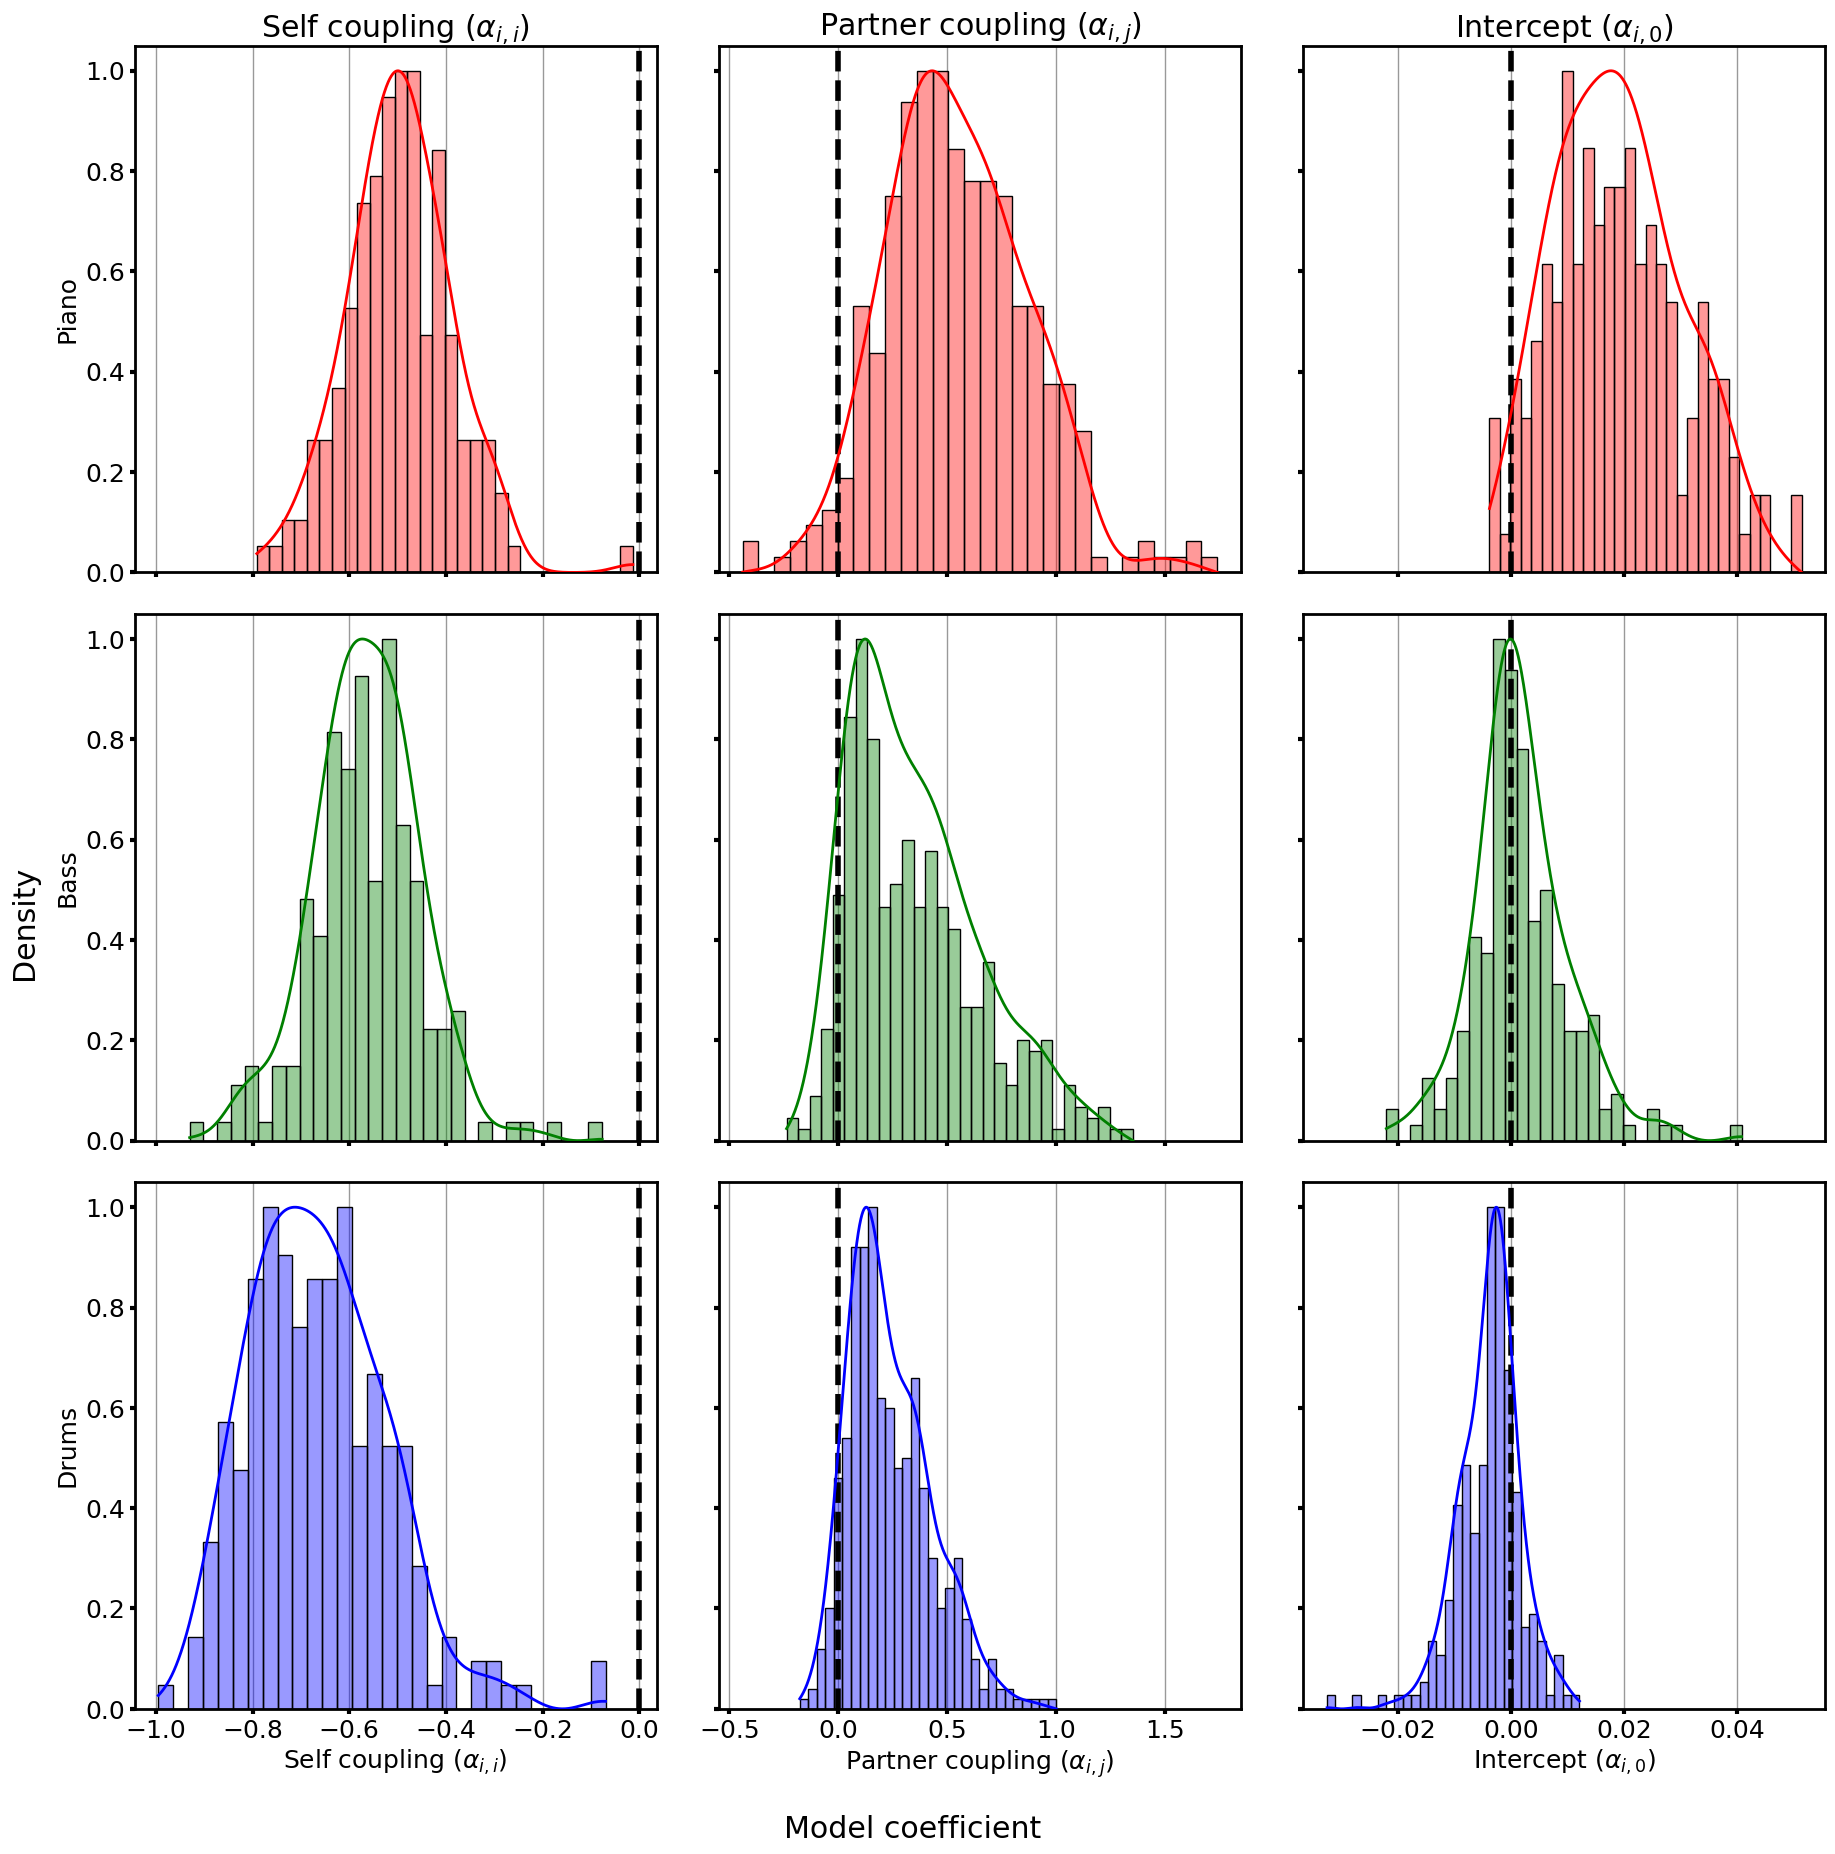

In [58]:
HistPlotCouplingTerms(clean).create_plot()
plt.show()

## Create triangle plot of mean coupling coefficients

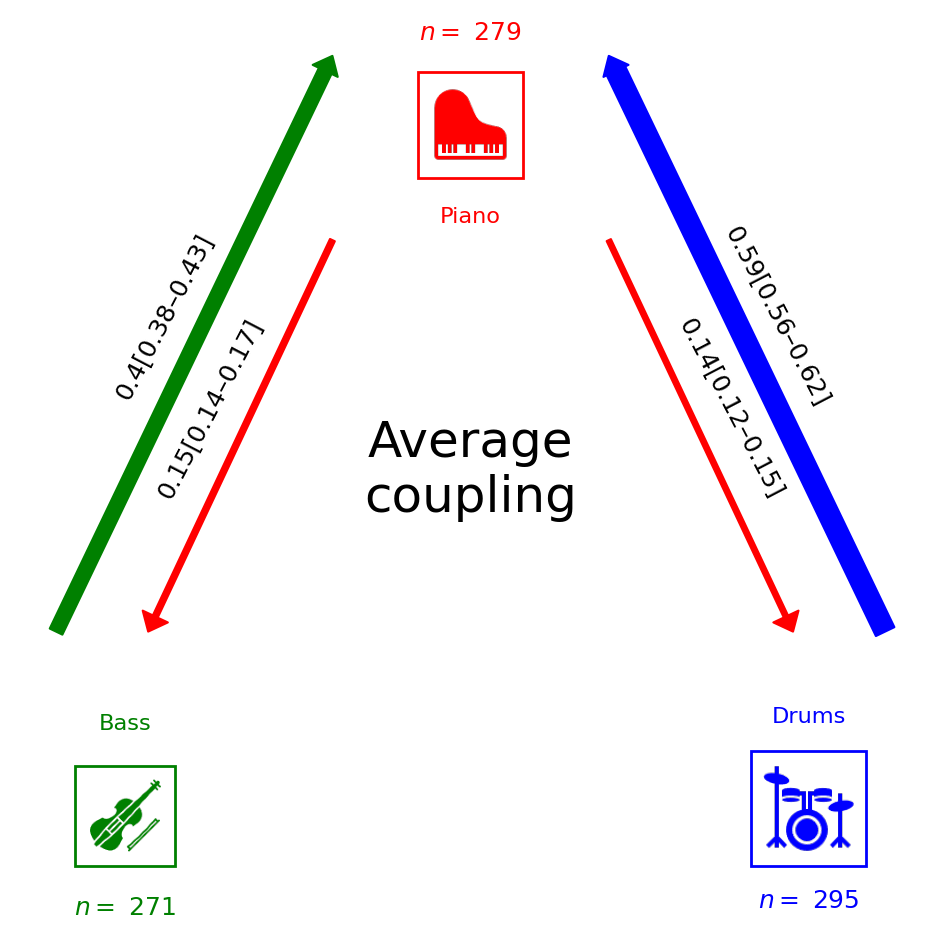

In [33]:
class TriangleWrapper(vutils.BasePlot):
    def __init__(self, model_df, **kwargs):
        self.corpus_title = kwargs.get('corpus_title', 'corpus_chronology')
        super().__init__(figure_title=fr'coordination_plots/triangleplot_alltrios_{self.corpus_title}', **kwargs)
        self.df = model_df.copy(deep=True)
        self.df.loc['pianist', :] = ''
        self.df['performer'] = ''
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))

    def _create_plot(self):
        TriangleAxis(self.df, self.ax, text_override='Average\ncoupling').create_plot()

    def _format_fig(self):
        self.fig.subplots_adjust(top=0.99, bottom=0.01, left=0.01, right=0.99)

TriangleWrapper(clean).create_plot()
plt.show()

## Create triangle plot for all individual trios

Ahmad Jamal
Bill Evans
Bud Powell
John Hicks
Junior Mance
Keith Jarrett
Kenny Barron
McCoy Tyner
Oscar Peterson
Tommy Flanagan


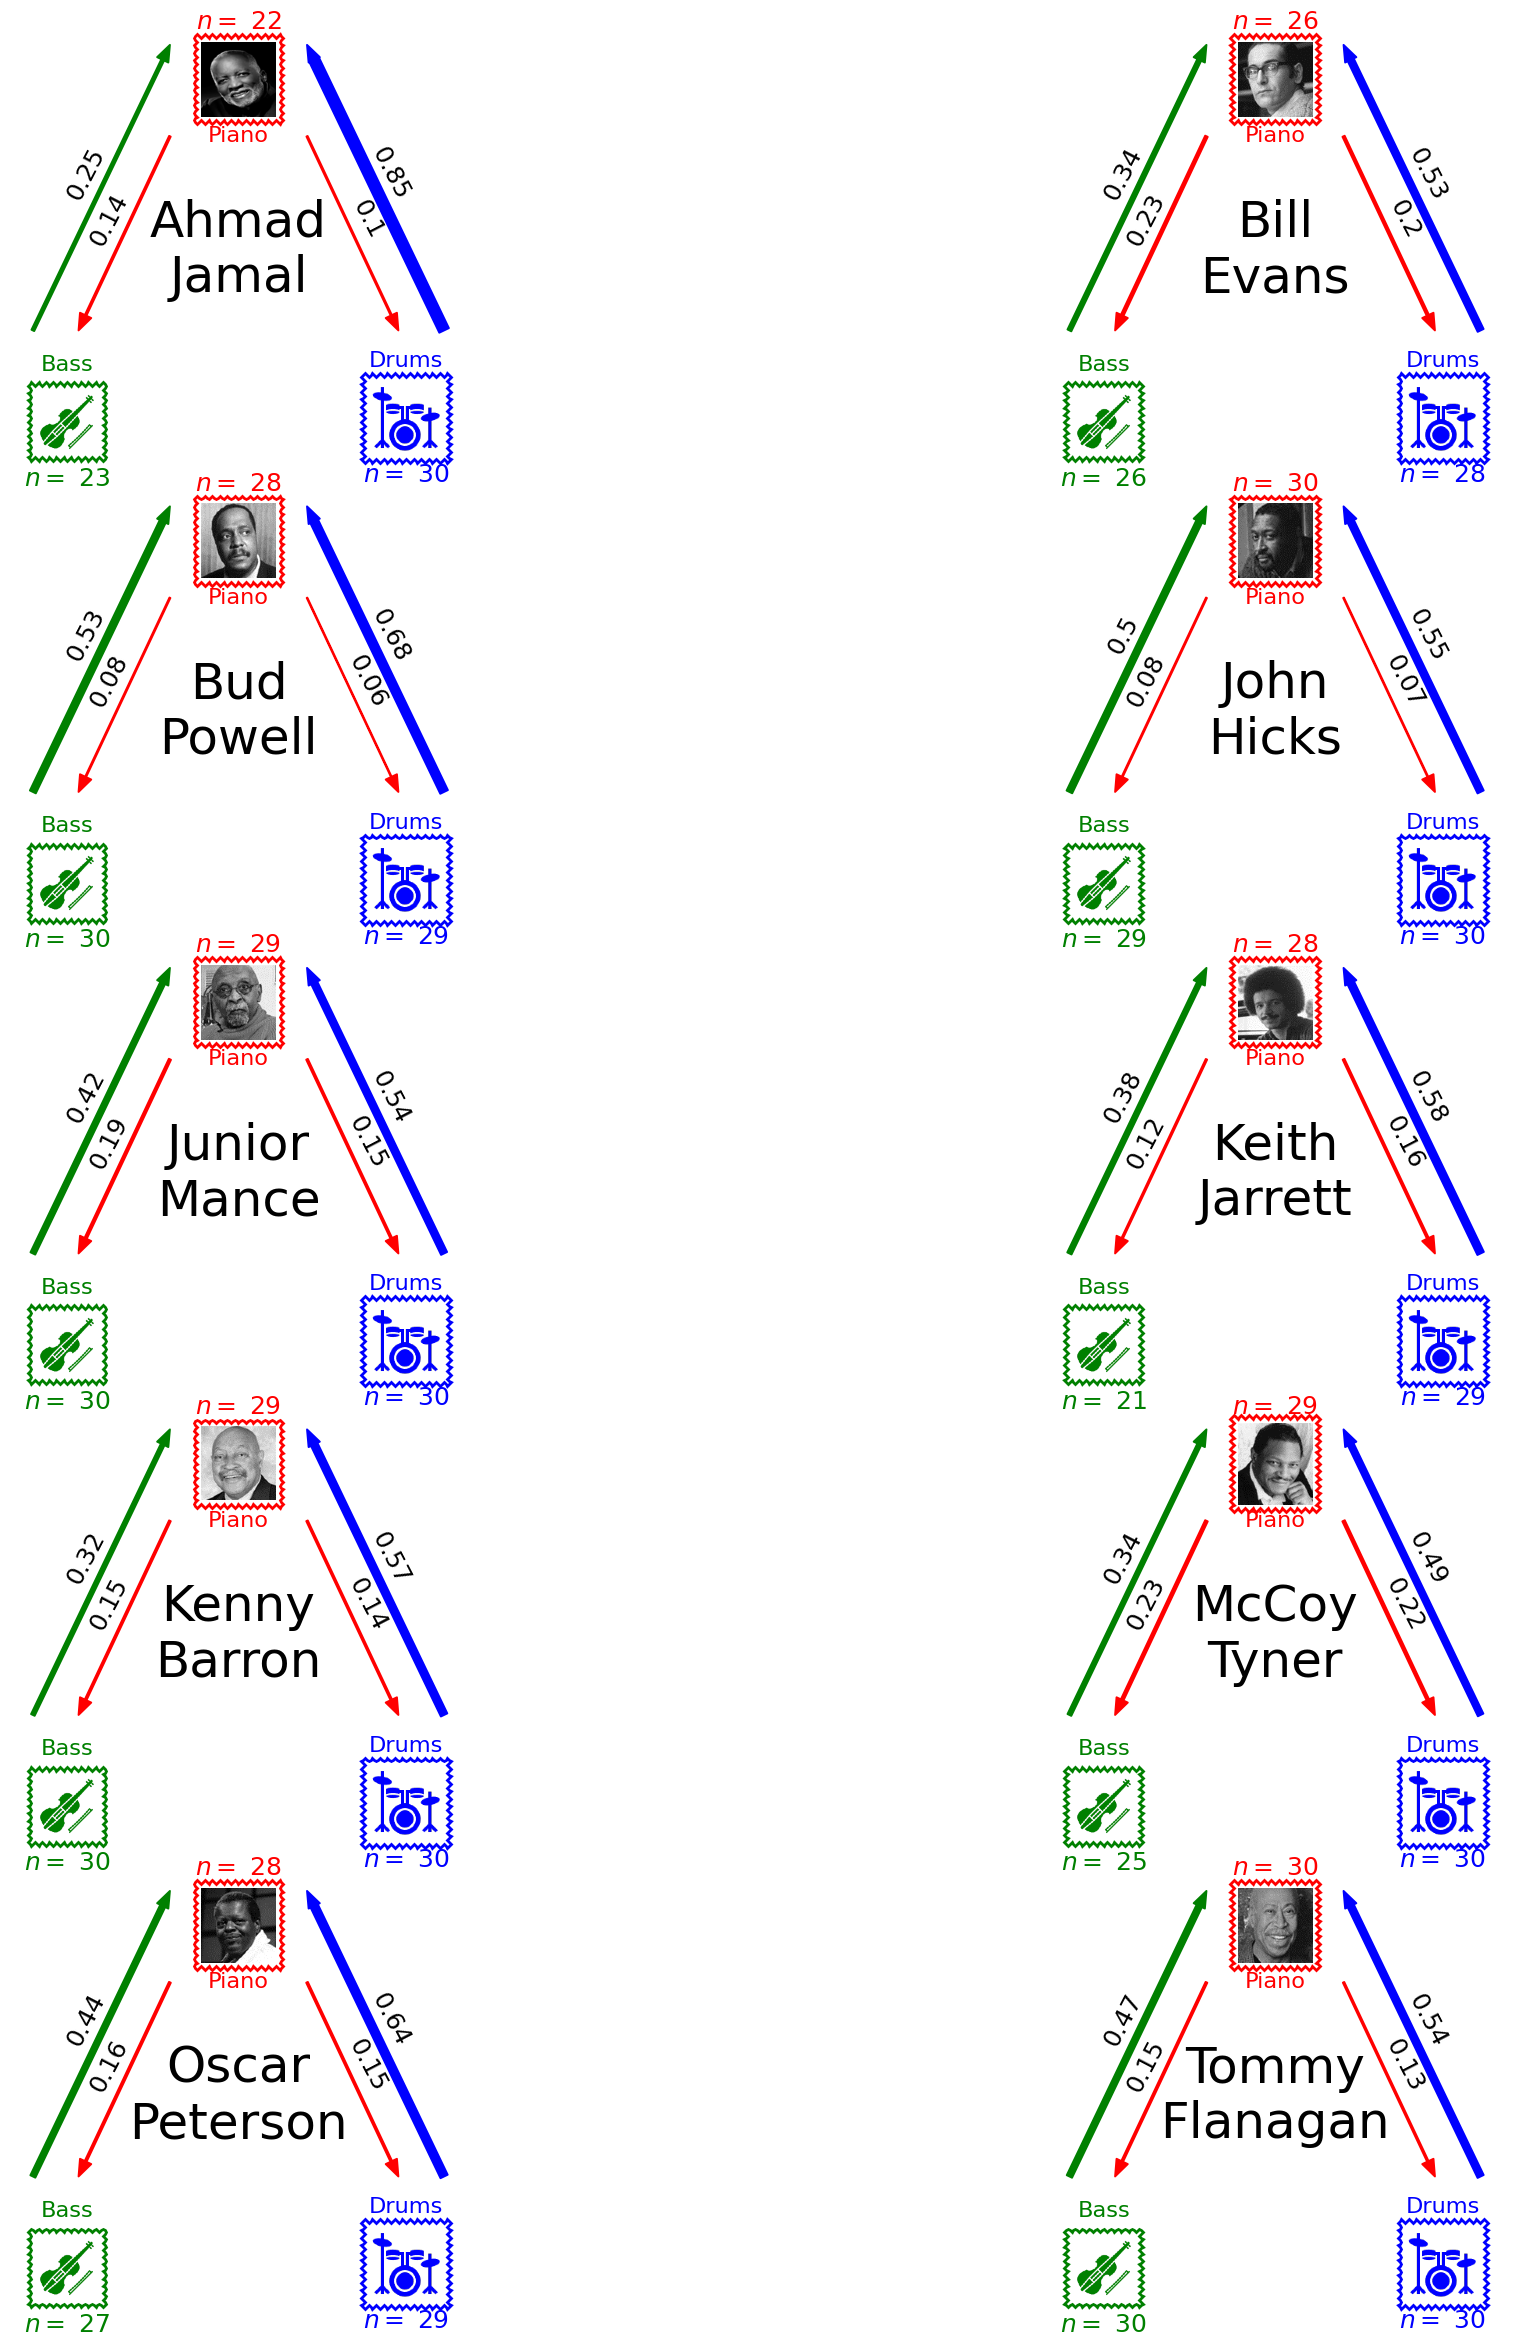

In [34]:
class TrianglePlotTrioWrapper(vutils.BasePlot):
    """Creates a triangle plot for each trio combination in JTD-300"""
    TRIANGLE_KWS = dict(
        starting_zoom=0.75, arrow_mod=9, head_width=9, len_mod=0.9,
        performer_picture_zoom=1.1, text_mod=0.125, ci=None
    )

    def __init__(self, trio_df: pd.DataFrame, **kwargs):
        self.corpus_title = kwargs.get('corpus_title', 'corpus')
        super().__init__(figure_title=fr'coordination_plots/triangleplot_trios_{self.corpus_title}', **kwargs)
        self.nobs_cutoff = kwargs.get('nobs_cutoff', 30)
        self.df = trio_df
        self.df.loc[self.df['instrument'] == 'piano', 'performer'] = self.df['pianist']
        self.df.loc[self.df['instrument'] != 'piano', 'performer'] = ""
        self.fig, self.ax = plt.subplots(nrows=5, ncols=2, figsize=(vutils.WIDTH, vutils.WIDTH * 5/4))

    def _create_plot(self):
        for a, (idx, grp) in zip(self.ax.flatten(), self.df.groupby('pianist')):
            print(idx)
            TriangleAxis(grp, a, **self.TRIANGLE_KWS).create_plot()

    def _format_fig(self):
        """Format figure-level parameters"""
        self.fig.subplots_adjust(left=-0.1, right=1.1, top=0.99, bottom=0.01, hspace=0.01, wspace=-0.15)


TrianglePlotTrioWrapper(clean).create_plot()
plt.show()

## Create bar plot of coupling coefficients

C:\Python Projects\jazz-corpus-analysis\src\visualise\coordination_plots.py:543: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  marker_df = self.df.groupby('variable').mean().reset_index(drop=False)


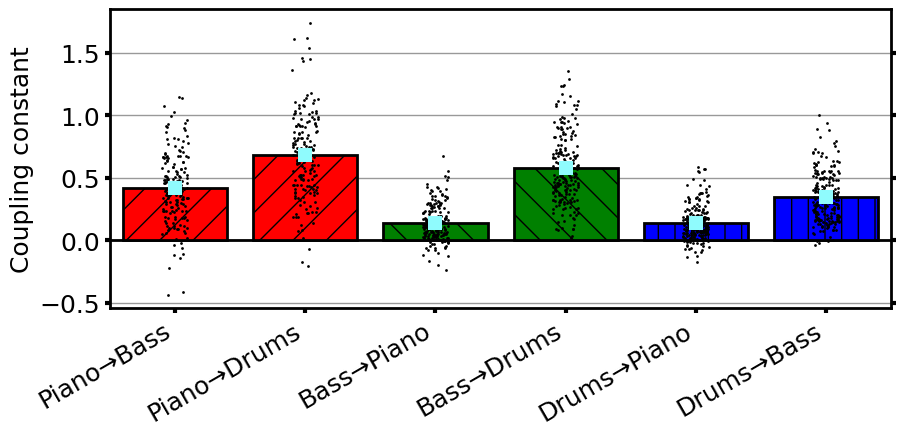

In [12]:
BarPlotCouplingCoefficients(clean).create_plot()
plt.show()

## Control analyses

### Compare coupling across 1st/2nd half of a track

In [ ]:
partial_models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Get the duration of the track
    duration = np.ceil(summary_dict['beats'].max())
    # Get the timestamps for the start and end of the first and second half
    first_half_range = 0, np.ceil(duration / 2)
    second_half_range = first_half_range[1], duration
    # Get the data for the first and second half using hte timestamps
    first_half = summary_dict[(first_half_range[0] <= summary_dict['beats']) & (summary_dict['beats'] <= first_half_range[1])]
    second_half = summary_dict[(second_half_range[0] <= summary_dict['beats']) & (summary_dict['beats'] <= second_half_range[1])]
    # Iterate over each half separately
    for data, half in zip([first_half, second_half], [1, 2]):
        # Create the model for each instrument from the data for each half
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            mine = data[instr]
            theirs = data[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
            partial_model = PhaseCorrection(my_beats=mine, their_beats=theirs)
            # Append the model results, plus some additional metadata
            partial_models.append(track.item | partial_model.summary_dict | dict(instrument=instr, half=half))
partial_df = pd.DataFrame(partial_models)

In [ ]:
# Get the minimum number of observations for a half, per instrument and track
small = (partial_df.groupby(['mbz_id', 'instrument'])['nobs'].min() >= 30).reset_index(drop=False)
checker = {}
# Iterate through the rows of the dataframe of acceptable/non-acceptable tracks
for idx, row in small[small['nobs']][['mbz_id', 'instrument']].iterrows():
    # If this row and instrument is acceptable, add the mbz_id as a dictionary key and the instrument to a list (value)
    if row['mbz_id'] not in checker.keys():
        checker[row['mbz_id']] = [row['instrument']]
    else:
        checker[row['mbz_id']].append(row['instrument'])

In [ ]:
# Get the acceptable rows in the full dataframe based on our dictionary of lists
is_ok = [row for _, row in partial_df.iterrows() if row['mbz_id'] in checker.keys() and row['instrument'] in checker[row['mbz_id']]]

In [ ]:
# Combine the acceptable rows into one dataframe and pivot to get coupling responses as their own column
melt = (
    pd.DataFrame(is_ok)
    .melt(id_vars=['mbz_id', 'half'], value_vars=['coupling_piano', 'coupling_drums', 'coupling_bass', 'half'])
    .dropna()
    .pivot_table(values='value', index=['mbz_id', 'variable'], columns='half')
    .reset_index(drop=False)
    .rename(columns={1: 'half_1', 2: 'half_2'})
)
melt['variable'] = melt['variable'].str.replace('coupling_', '')

In [ ]:
RegPlotCouplingHalves(melt).create_plot()
plt.show()

### Compare coupling, granger causality, and cross-correlation

In [ ]:
RegPlotCouplingGrangerCross(clean).create_plot()
plt.show()

### Compare higher-order models

In [67]:
models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Iterate over every instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Subset to get my onsets and partner onsets as separate dataframes
        mine = summary_dict[instr]
        theirs = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
        # Iterate through the desired range of model orders (up to k = 4)
        for order in range(1, 5):
            # Create models - phase correction
            model = PhaseCorrection(my_beats=mine, their_beats=theirs, order=order)
            # Append summary results for creating a dataframe
            models.append(dict(
                instr=instr, id=track.item['mbz_id'], nobs=model.summary_dict['nobs'],
                r2=model.summary_dict['rsquared_adj'], bic=model.summary_dict['bic'],
                order=order,
            ))
# Create the dataframe
high_df = pd.DataFrame(models)

In [ ]:
# Get the number of missing values per track-instrument combination
high_df['nan_count'] = high_df.groupby(['id', 'instr'])['r2'].transform(lambda x: x.isnull().sum())
high_df['nobs_count'] = high_df.groupby(['id', 'instr'])['nobs'].transform(lambda x: x.min())
# Remove tracks with more than 1 missing value and not enough observations
high_df_clean = high_df[(high_df['nan_count'] < 1) & (high_df['nobs_count'] > 30)].reset_index(drop=True)

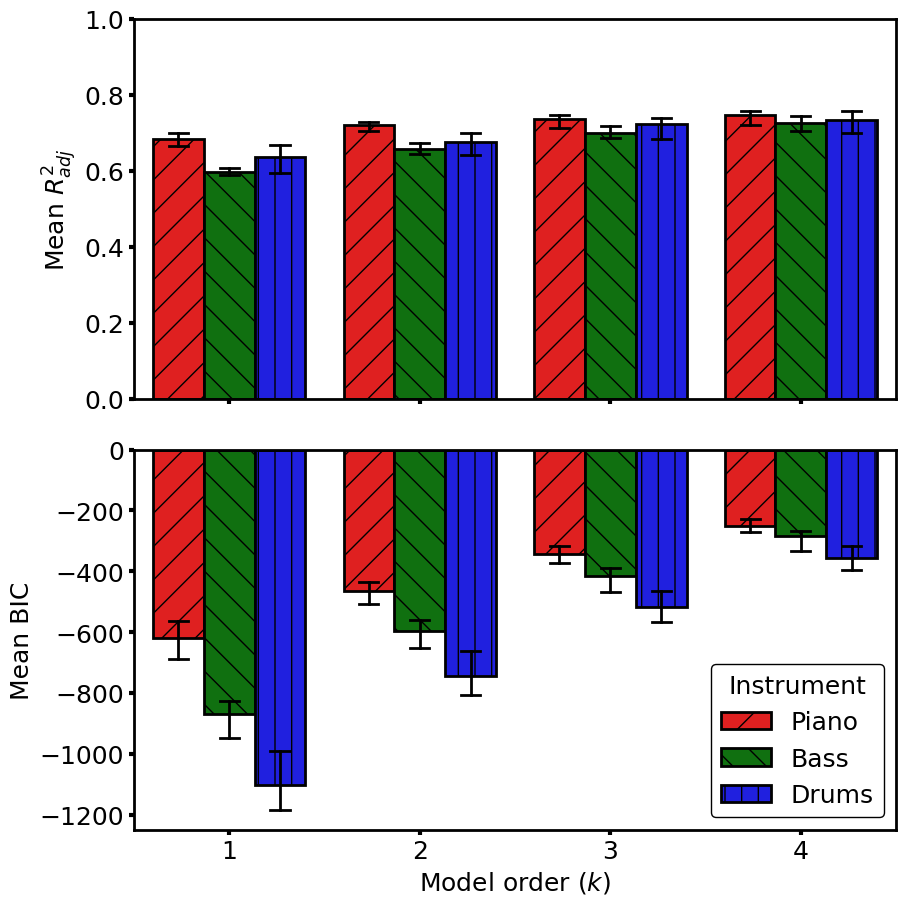

In [84]:
BarPlotModelComparison(high_df_clean).create_plot()
plt.show()

## Simulations: individual strategies

### Get parameters for simulations

In [85]:
cols = ['self_coupling', 'coupling_piano', 'coupling_bass', 'coupling_drums', 'resid_std', 'intercept']
params = (
    clean.groupby('instrument')
    [cols]
    .mean()
    .to_dict(orient='index')
)

In [86]:
# Get mean parameters from our original parameters
mean_coupling = np.nanmean(clean[['coupling_piano', 'coupling_drums', 'coupling_bass']].values.flatten())
mean_self_coupling = np.nanmean(clean['self_coupling'].values)
mean_intercept = np.nanmean(clean['intercept'].values)
noise_constant = 0.005

In [97]:
total_coupling_strength = sum(sum(i for k, i in params[instr].items() if 'coupling_' in k and not np.isnan(i)) for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys())

### Create simulations using original coupling parameters

In [98]:
original_params = {
    'piano': {
        **params['piano'],
    },
    'bass': {
        **params['bass'],
    },
    'drums': {
        **params['drums'],
    },
}

In [99]:
original = SimulationManager(original_params, tempo=120, n_sims=500)
original.run_simulations()
original.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.8s finished


0.014088215921108932

### Create democracy simulations

In [100]:
balanced_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': total_coupling_strength / 6,
        'coupling_drums': total_coupling_strength / 6,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': total_coupling_strength / 6,
        'coupling_drums': total_coupling_strength / 6,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': total_coupling_strength / 6,
        'coupling_bass': total_coupling_strength / 6,
    }
}

In [101]:
balanced = SimulationManager(balanced_params, tempo=120, n_sims=500)
balanced.run_simulations()
balanced.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.8s finished


0.015568555826353716

### Create anarchy simulations

In [102]:
no_coupling_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': 0,
    }
}

In [103]:
no_coupling = SimulationManager(no_coupling_params, tempo=120, n_sims=500)
no_coupling.run_simulations()
no_coupling.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.6s finished


18.459335953190173

### Create drummer-leader simulations

In [104]:
drums_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': total_coupling_strength / 2,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': total_coupling_strength / 2,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': 0,
    }
}

In [105]:
drums_leader = SimulationManager(drums_leader_params, tempo=120, n_sims=500)
drums_leader.run_simulations()
drums_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.5s finished


0.014628064384321432

### Create bass leader simulations

In [106]:
bass_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': total_coupling_strength / 2,
        'coupling_drums': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': total_coupling_strength / 2,
    }
}

In [107]:
bass_leader = SimulationManager(bass_leader_params, tempo=120, n_sims=500)
bass_leader.run_simulations()
bass_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.5s finished


0.015240045075225363

### Create piano leader simulations

In [108]:
piano_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': total_coupling_strength / 2,
        'coupling_drums': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': total_coupling_strength / 2,
        'coupling_bass': 0,
    }
}

In [109]:
piano_leader = SimulationManager(piano_leader_params, tempo=120, n_sims=500)
piano_leader.run_simulations()
piano_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.0s finished


0.016320848225413048

### Plot proportional RMS

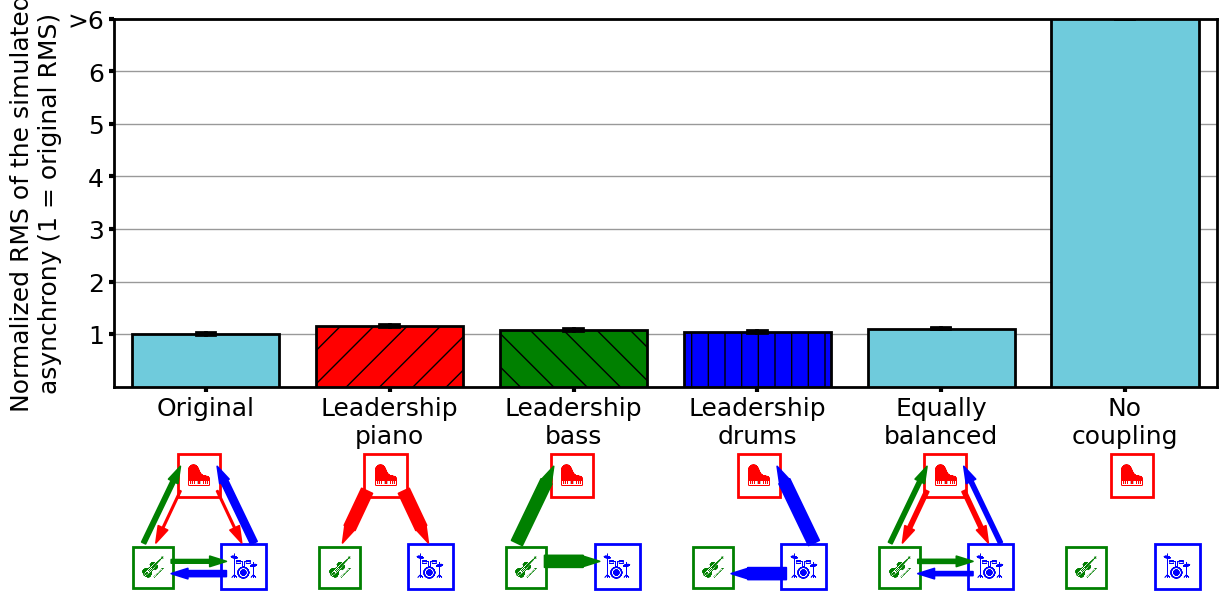

In [110]:
BarPlotSimulationComparison(
    all_sims=[original, piano_leader, bass_leader, drums_leader, balanced, no_coupling],
    all_params=[params, piano_leader_params, bass_leader_params, drums_leader_params, balanced_params, no_coupling_params]
).create_plot()